In [1]:
import torch.nn as nn
import torch
import math

In [2]:
# InputEmbeddings: Nhúng Embedding
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

In [3]:
# Position Encodings: Mã hóa vị trí
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        
        # Tạo ma trận lưu trữ mã hóa vị trí
        self.pe = torch.zeros(seq_len, d_model)
        
        # Tạo ma trận vị trí (0, 1, 2, 3, ..., seq_len-1)
        self.position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        
        # Tạo ma trận mã hóa
        self.div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Áp dụng hàm Sin cho các vị trí chẵn
        self.pe[:, 0::2] = torch.sin(self.position * self.div_term)
        
        # Áp dụng hàm Cos cho các vị trí lẻ
        self.pe[:, 1::2] = torch.cos(self.position * self.div_term)
        
        # Thêm một chiều mới ở vị trí đầu tiên => (1, seq_len, d_model)
        self.pe = self.pe.unsqueeze(0)# (1, seq_len, d_model)

        # Đảm bảo pe sẽ được lưu trữ và điều chỉnh cùng trạng thái mô hình, không cập nhập trong quá trình huấn luyện
        self.register_buffer('pe', self.pe)
    
    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

In [4]:
# LayerNormalization: Chuẩn hóa theo lớp
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps
        
        # aplpha và bias là hai tham số cần học
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        # Tính giá trị TB của x theo chiều cuối cùng
        mean = x.mean(dim=-1, keepdim=True)
        
        # Tính độ lệch chuẩn của x theo chiều cuối cùng
        std = x.std(dim=-1, keepdim = True)
        
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [5]:
# Multihead attention
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Chiều của một vector embedding
        
        self.h = h # Số lượng head attention
        
        # Đảm bảo rằng số chiều vector embedding chia hết cho số lượng head attention
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Số chiều của vector embedding của mỗi head attention sau khi được chia
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq (query matrix)
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk (Key matrix)
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv (value matrix)
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo (Output matrix)
        self.dropout = nn.Dropout(dropout) # Dropout

    # Hàm tĩnh thực hiện attention và tính attention scores
    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        # query is shape (batch_size, head, seq_len, d_k)
        # key is shape (batch_size, head, seq_len, d_k)
        # value is shape (batch_size, head, seq_len, d_k)
        
        # Chiều của mỗi head attention
        d_k = query.shape[-1]
        
        # (batch_size, head, seq_len, d_k) --> (batch, head, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        
        # Thực hiện softmax trên attention scores
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        
        # Thực hiện dropout
        if dropout is not None:
            attention_scores = dropout(attention_scores)
            
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        # q is shape (batch_size, seq_len, d_model)
        # k is shape (batch_size, seq_len, d_model)
        # v is shape (batch_size, seq_len, d_model)
        
        query = self.w_q(q) # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)
        key = self.w_k(k)   # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)
        value = self.w_v(v) # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)

        # (batch_size, seq_len, d_model) --split--> (batch_size, seq_len, head, d_k) --> (batch_size, head, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Tính attention và attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Kết hợp tất cả các head attentionlaij với nhau
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)


In [6]:
# Feed For Ward Block: Mạng lưới thần kinh
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [7]:
# Residual Connection: Khối liên kết(Bao gồm 1 block + 1 Add & Norm)
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            
            # Add & Norm bao gồm LayerNormalization + Dropout
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

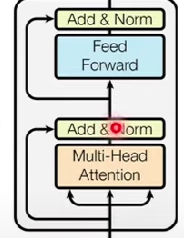

In [8]:
# Encoder Block
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        
        # Khối Multihead Attention
        self.self_attention_block = self_attention_block
        
        # Khối FeedForWard
        self.feed_forward_block = feed_forward_block
        
        # Khối liên kết gồm 2 khối
        # Khối 1: Multi-Head Attention + Add & Norm
        # Khối 2: Feed Forward + Add & Norm
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [9]:
# Encoder
# Encoder bao gồm 6 EncoderBlocks
class Encoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers # EncoderBlocks
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

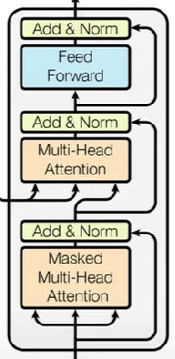

In [10]:
# DecoderBlock
class DecoderBlock(nn.Module):

    def __init__(self, features: int,
                 self_attention_block: MultiHeadAttentionBlock,
                 cross_attention_block: MultiHeadAttentionBlock,
                 feed_forward_block: FeedForwardBlock,
                 dropout: float) -> None:
        
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # Khối liên kết 1: Masked Multi-Head Attention + Add & Norm
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        
        # Khối liên kết 2: Multi-Head Attention + Add & Norm
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        
        # Khối liên kết 3: Feed Forward + Add & Norm
        x = self.residual_connections[2](x, self.feed_forward_block)
        
        return x

In [11]:
# Decoder
# Decoder bao gồm 3 DecoderBlocks
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

In [12]:
# Chiếu dữ liệu thành vector vocab
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

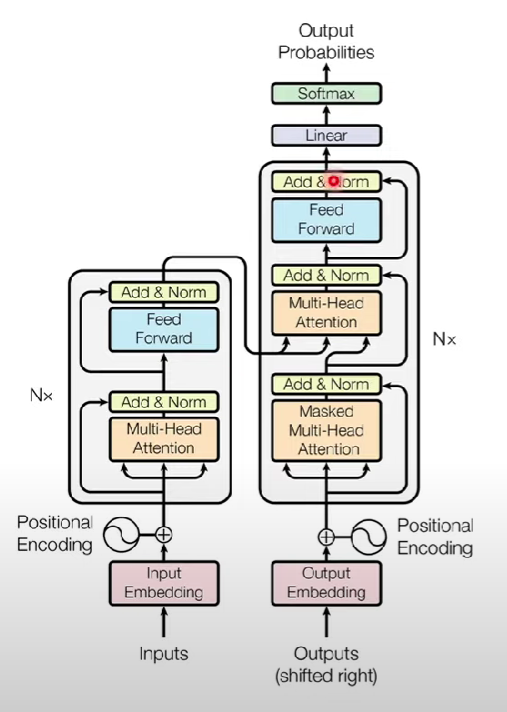

In [13]:
# Transformer
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder,            # Encoder
                 decoder: Decoder,                  # Decoder
                 src_embed: InputEmbeddings,        # Input Embedding
                 tgt_embed: InputEmbeddings,        # Output Embedding
                 src_pos: PositionalEncoding,       # Positional Encoding from input
                 tgt_pos: PositionalEncoding,       # Positional Encoding from output
                 projection_layer: ProjectionLayer  # Linear
                 ) -> None:
        
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)

In [15]:
def build_transformer(src_vocab_size: int,
                      tgt_vocab_size: int,
                      src_seq_len: int,
                      tgt_seq_len: int,
                      d_model: int=512,
                      N: int=6, h: int=8,
                      dropout: float=0.1,
                      d_ff: int=2048) -> Transformer:
    # Tạo 2 khối Input Embeddings
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Tạo 2 khối Positional Encodings
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Tạo Encoder blocks
    encoder_blocks = []
    
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Tạo Decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Tạo encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    # Tạo projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Tạo transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Khởi tạo các tham số của mô hình transformer
    for p in transformer.parameters():
        if p.dim() > 1:
            # Khởi tạo các tham số mô hình theo phương pháp Xavier Uniform
            nn.init.xavier_uniform_(p)
    
    return transformer